<a href="https://colab.research.google.com/github/irdazh/house-price-prediction/blob/main/notebooks/house_pp_eval_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# APP Model Evaluation (Colab)
> **Please, do not run**

It's an exploratory notebooks since my laptop is so **bapuk**.
Guess I'll do lots of work here, before copy-pasting and make it into chunks in the local notebooks. Well, as with git things, it should be updated manually to GitHub (and rewrite, there isn't anything called edit).  

In [1]:
!pip install -U scikit-learn
import sklearn
print(sklearn.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 41.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.0 which is incompatible.
1.7.0


In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# selection & preprocess
from sklearn.model_selection import GridSearchCV, KFold, train_test_split

# from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer, OrdinalEncoder, OneHotEncoder, RobustScaler
from sklearn.metrics import mean_squared_error, make_scorer, root_mean_squared_log_error, root_mean_squared_error

# save
import joblib

# model explanation
import shap
from sklearn.inspection import permutation_importance


## Load data & model
Split model as well

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/irdazh/house-price-prediction/refs/heads/main/data/train.csv')
df.drop(columns='Id', inplace=True)
display(df.head())

y = df['SalePrice']
X = df.drop('SalePrice', axis=1)

# remove high missing cols
X.drop('PoolQC MiscFeature Alley Fence'.split(), axis=1, errors='ignore')

num_var = X.select_dtypes(include='number').columns
ord_var = X.select_dtypes(include='object').columns

# splitting data
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = 0.2, random_state = 42)
display(X_tr, X_te)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
254,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1066,60,RL,59.0,7837,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal
638,30,RL,67.0,8777,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,5,2008,WD,Normal
799,50,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,0,NaN,MnPrv,NaN,0,6,2007,WD,Normal
380,50,RL,50.0,5000,Pave,Pave,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,20,RL,78.0,9317,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,3,2007,WD,Normal
1130,50,RL,65.0,7804,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,12,2009,WD,Normal
1294,20,RL,60.0,8172,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Normal
860,50,RL,55.0,7642,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,0,NaN,GdPrv,NaN,0,6,2007,WD,Normal


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
892,20,RL,70.0,8414,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,2,2006,WD,Normal
1105,60,RL,98.0,12256,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
413,30,RM,56.0,8960,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,3,2010,WD,Normal
522,50,RM,50.0,5000,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,10,2006,WD,Normal
1036,20,RL,89.0,12898,Pave,NaN,IR1,HLS,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2009,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,30,RM,50.0,5925,Pave,NaN,Reg,Bnk,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2007,WD,Alloca
1361,20,RL,124.0,16158,Pave,NaN,IR1,Low,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal
802,60,RL,63.0,8199,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,10,2008,WD,Normal
651,70,RL,60.0,9084,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,10,2009,WD,Normal


In [4]:
# load model
!wget https://raw.githubusercontent.com/irdazh/house-price-prediction/main/models/best_tuned01.joblib

import joblib
model = joblib.load('best_tuned01.joblib')

--2025-07-11 00:04:41--  https://raw.githubusercontent.com/irdazh/house-price-prediction/main/models/best_tuned01.joblib
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244326 (239K) [application/octet-stream]
Saving to: ‘best_tuned01.joblib’

best_tuned01.joblib 100%[===================>] 238.60K  --.-KB/s    in 0.04s   

2025-07-11 00:04:41 (6.62 MB/s) - ‘best_tuned01.joblib’ saved [244326/244326]



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:04:42] WARNING: /workspace/src/collective/../data/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


In [5]:
model

,steps,"[('pre', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('ord', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Retrain
On full set, tho usually, it's been refit.


In [6]:
model.fit(X_tr, y_tr)

,steps,"[('pre', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('ord', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Model Evaluation


In [7]:
dfp = X_te.copy()
dfp["Real"] = y_te.copy()
dfp["Pred"] = model.predict(X_te)

# Predict & evaluate on test set
rmse = root_mean_squared_error(dfp.Real, dfp.Pred)
msle = root_mean_squared_log_error(dfp.Real, dfp.Pred)
print("Test RMSE:", round(rmse), "\nTest MSLE", round(msle,3)), rmse/163000*100


Test RMSE: 25612 
Test MSLE 0.138


(None, 15.712866660276074)

Text(0.5, 1.0, 'Prediction vs Real Sale Price')

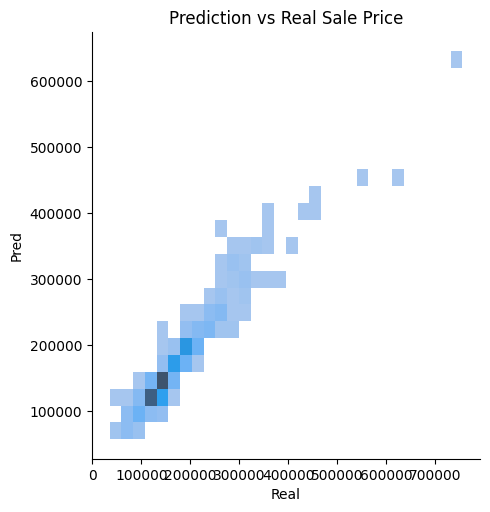

In [8]:
sns.displot(dfp, x="Real", y="Pred")
plt.title("Prediction vs Real Sale Price")

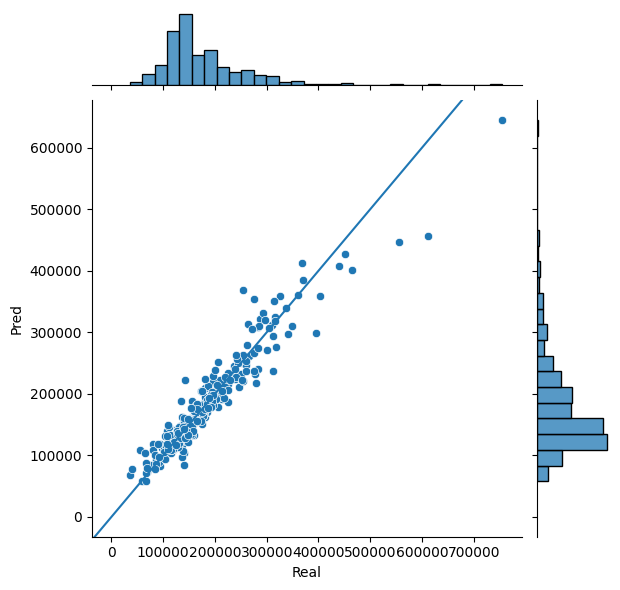

In [9]:
# works pretty well with lower price, but do underestimate for higher price
# this kind of underestimation is kinda good tho?
sns.jointplot(dfp, x="Real", y="Pred")
plt.axline(xy1=(0,0), slope=1)

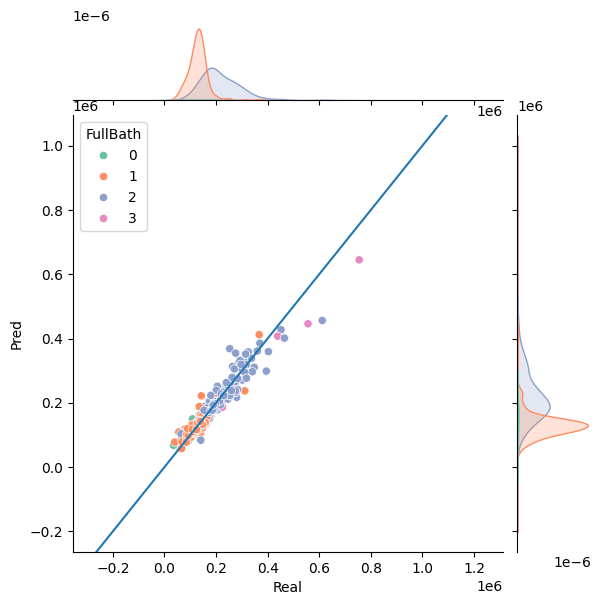

In [10]:
# Let's try fullbath view, still hard to see, tho.
sns.jointplot(dfp, x="Real", y="Pred", hue='FullBath', palette='Set2')
plt.axline(xy1=(0,0), slope=1)


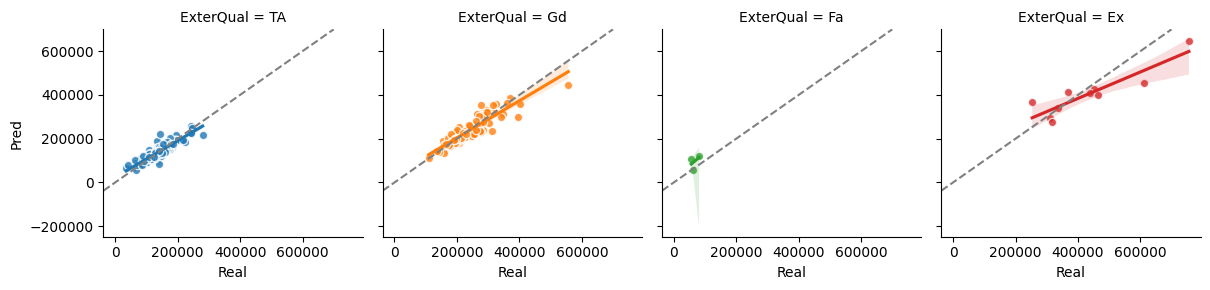

In [11]:

# how about this one? interpret it urself
g = sns.lmplot(
    x="Real", y="Pred", hue="ExterQual", col="ExterQual",
    data=dfp, scatter_kws={"edgecolor": 'w'}, col_wrap=5, height=3,
)

for i in g.axes:
  i.axline((0, 0), slope=1, color="gray", linestyle="--")

## Feature Importance

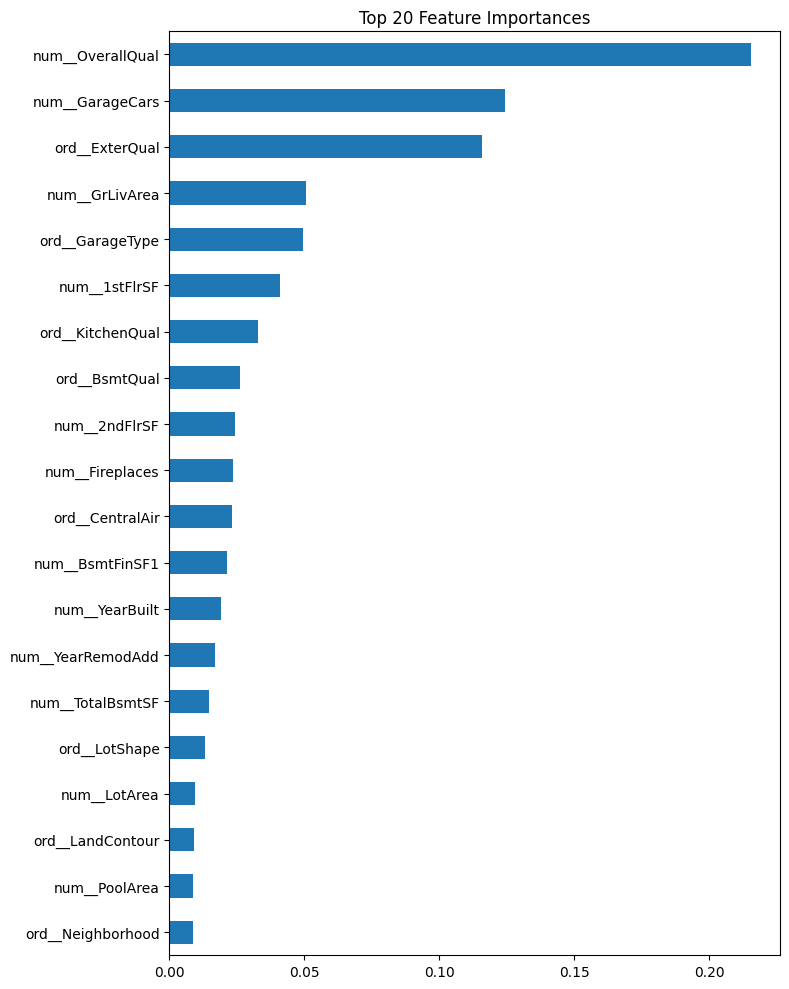

In [12]:
feature_names = model.named_steps['pre'].get_feature_names_out()
importances = model.named_steps['model'].feature_importances_

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
feat_imp.head(20).plot(kind='barh', figsize=(8, 10))
plt.title("Top 20 Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## More on Feature Importance.
Let's use SHAP for a more thorough model explanation!
1. **Permutation Importance**: I got an unexpected result from this, lol.
2. General SHAP:
3. Individual SHAP:


In [70]:
# permutation importance.
perm = permutation_importance(model, X_te, y_te, n_repeats=20,
                       random_state=0, n_jobs=-1)


<Axes: >

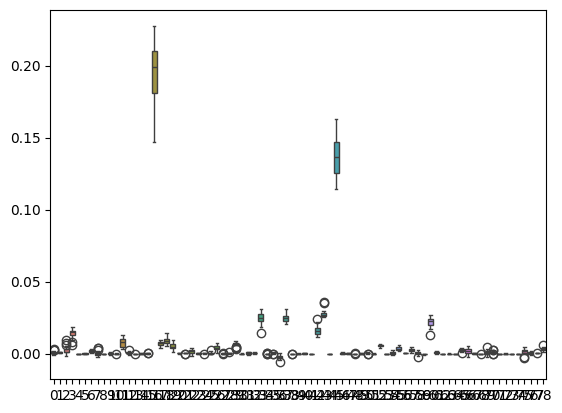

In [71]:
sns.boxplot(perm["importances"].transpose())

<Axes: xlabel='importance', ylabel='feature'>

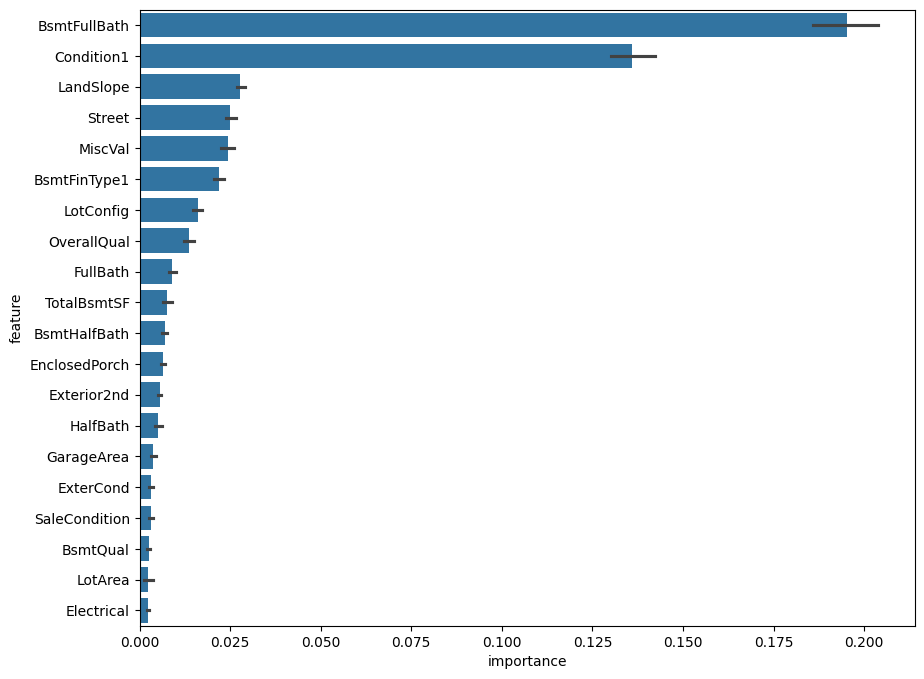

In [94]:
# whoah it's kinda messed up?
perm["importances_mean"]

perm2 = pd.DataFrame({'feature': [j.split("__")[1] for j in model.named_steps['pre'].get_feature_names_out()]*20,
                     'importance': perm["importances"].transpose().reshape(-1)})

feat20 = perm2.groupby('feature').mean('importance').sort_values('importance', ascending=False).head(20).index

perm2 = perm2.sort_values('importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=perm2[perm2.feature.isin(feat20)],
            order=feat20)


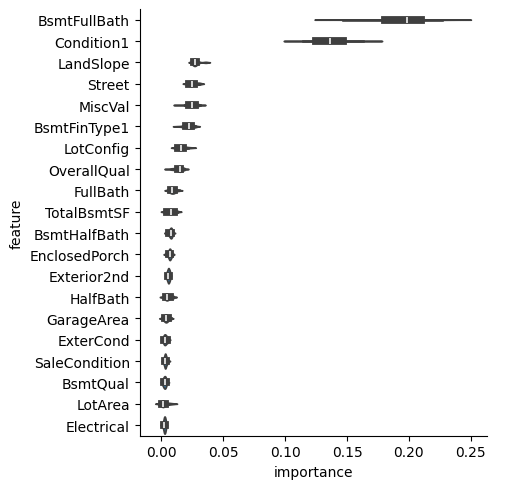

In [95]:
sns.catplot(x='importance', y='feature', data=perm2[perm2.feature.isin(feat20)],
            kind="violin", order=feat20)

**Insight**
- Based on permutation importance above, BmstFullBath & Condition1 are the most important feature, meanwhile OverallQual in 8th position
- That's kinda unexpected since we expect OverallQual to be the most important feature, rather than the first two.
- Some probable explanation? There might be some feature that's highly correlated. Therefore, even though it actually is important, since they can be predicted using other feature, it doesn't matter whether we shuffle that feature or not (?) Nah, i don't really know tho.

IDK, a useless code?

    mod, dat = moData(model, data)
    explain = shap.TreeExplainer(mod, approximate=True)
    shapval = explain(dat)
    return shapval, dat, explain

In [180]:
int(np.sqrt(24))+1

5

In [182]:
# General Shap
def id_shap1(model, data, pre="pre", alg="model", which="all"):
    mod, dat = moData(model, data)
    shapval = shap.TreeExplainer(mod, approximate=True).shap_values(dat)
    return shapval, dat

def pl_shap1(val, data):
    shap.summary_plot(val, data)
    # shap.summary_plot(val, data, plot_type="violin", color='coolwarm')

def pl_shap2(val, data, cols = None):
    if cols == None: cols = data.columns[:25]
    en = int(np.sqrt(len(cols))+0.9)

    fig, axes = plt.subplots(en, en, figsize=(20,16))
    axes = axes.ravel()
    display(axes)


    for i, var in enumerate(cols):
        shap.dependence_plot(var, val, data, ax=axes[i], show=False)
    plt.tight_layout()
    plt.show()

valx, datx = id_shap1(model, X_te)

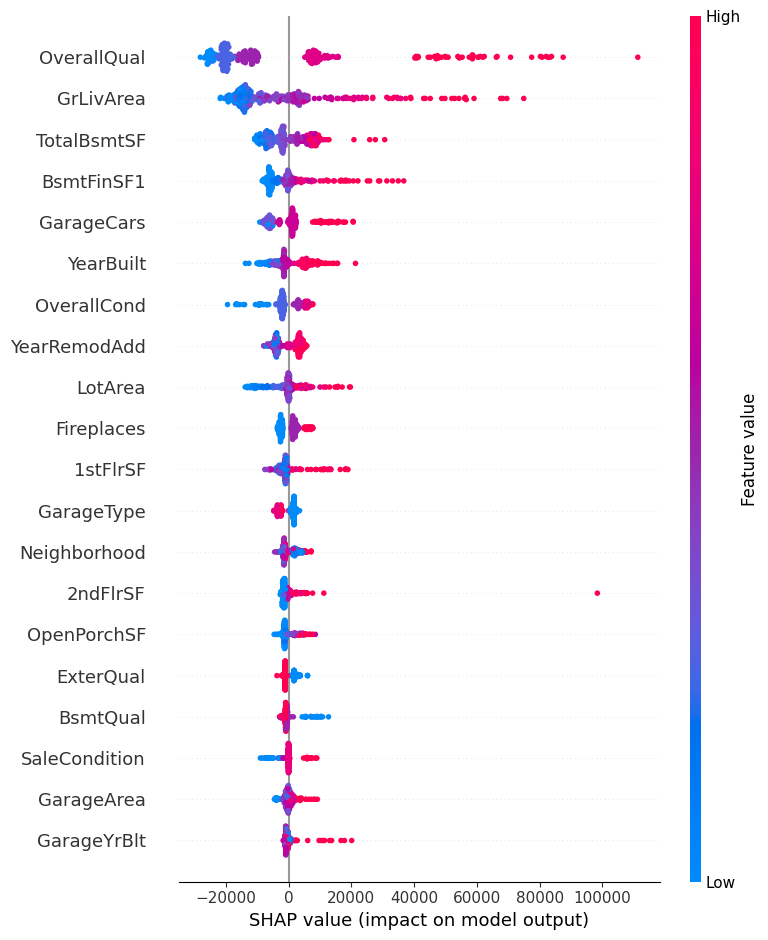

In [174]:
pl_shap1(valx, datx)

**Insight**
- 5 most important features: OverallQual, GrLivArea, TotalBsmtSF, BsmtFinSF1, and GarageCars (more reasonable than the previous permutation importance)
- For all of those 5 features, its affect the house price in a positive way: increase in those features makes the house price tend to increase as well.


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >], dtype=object)

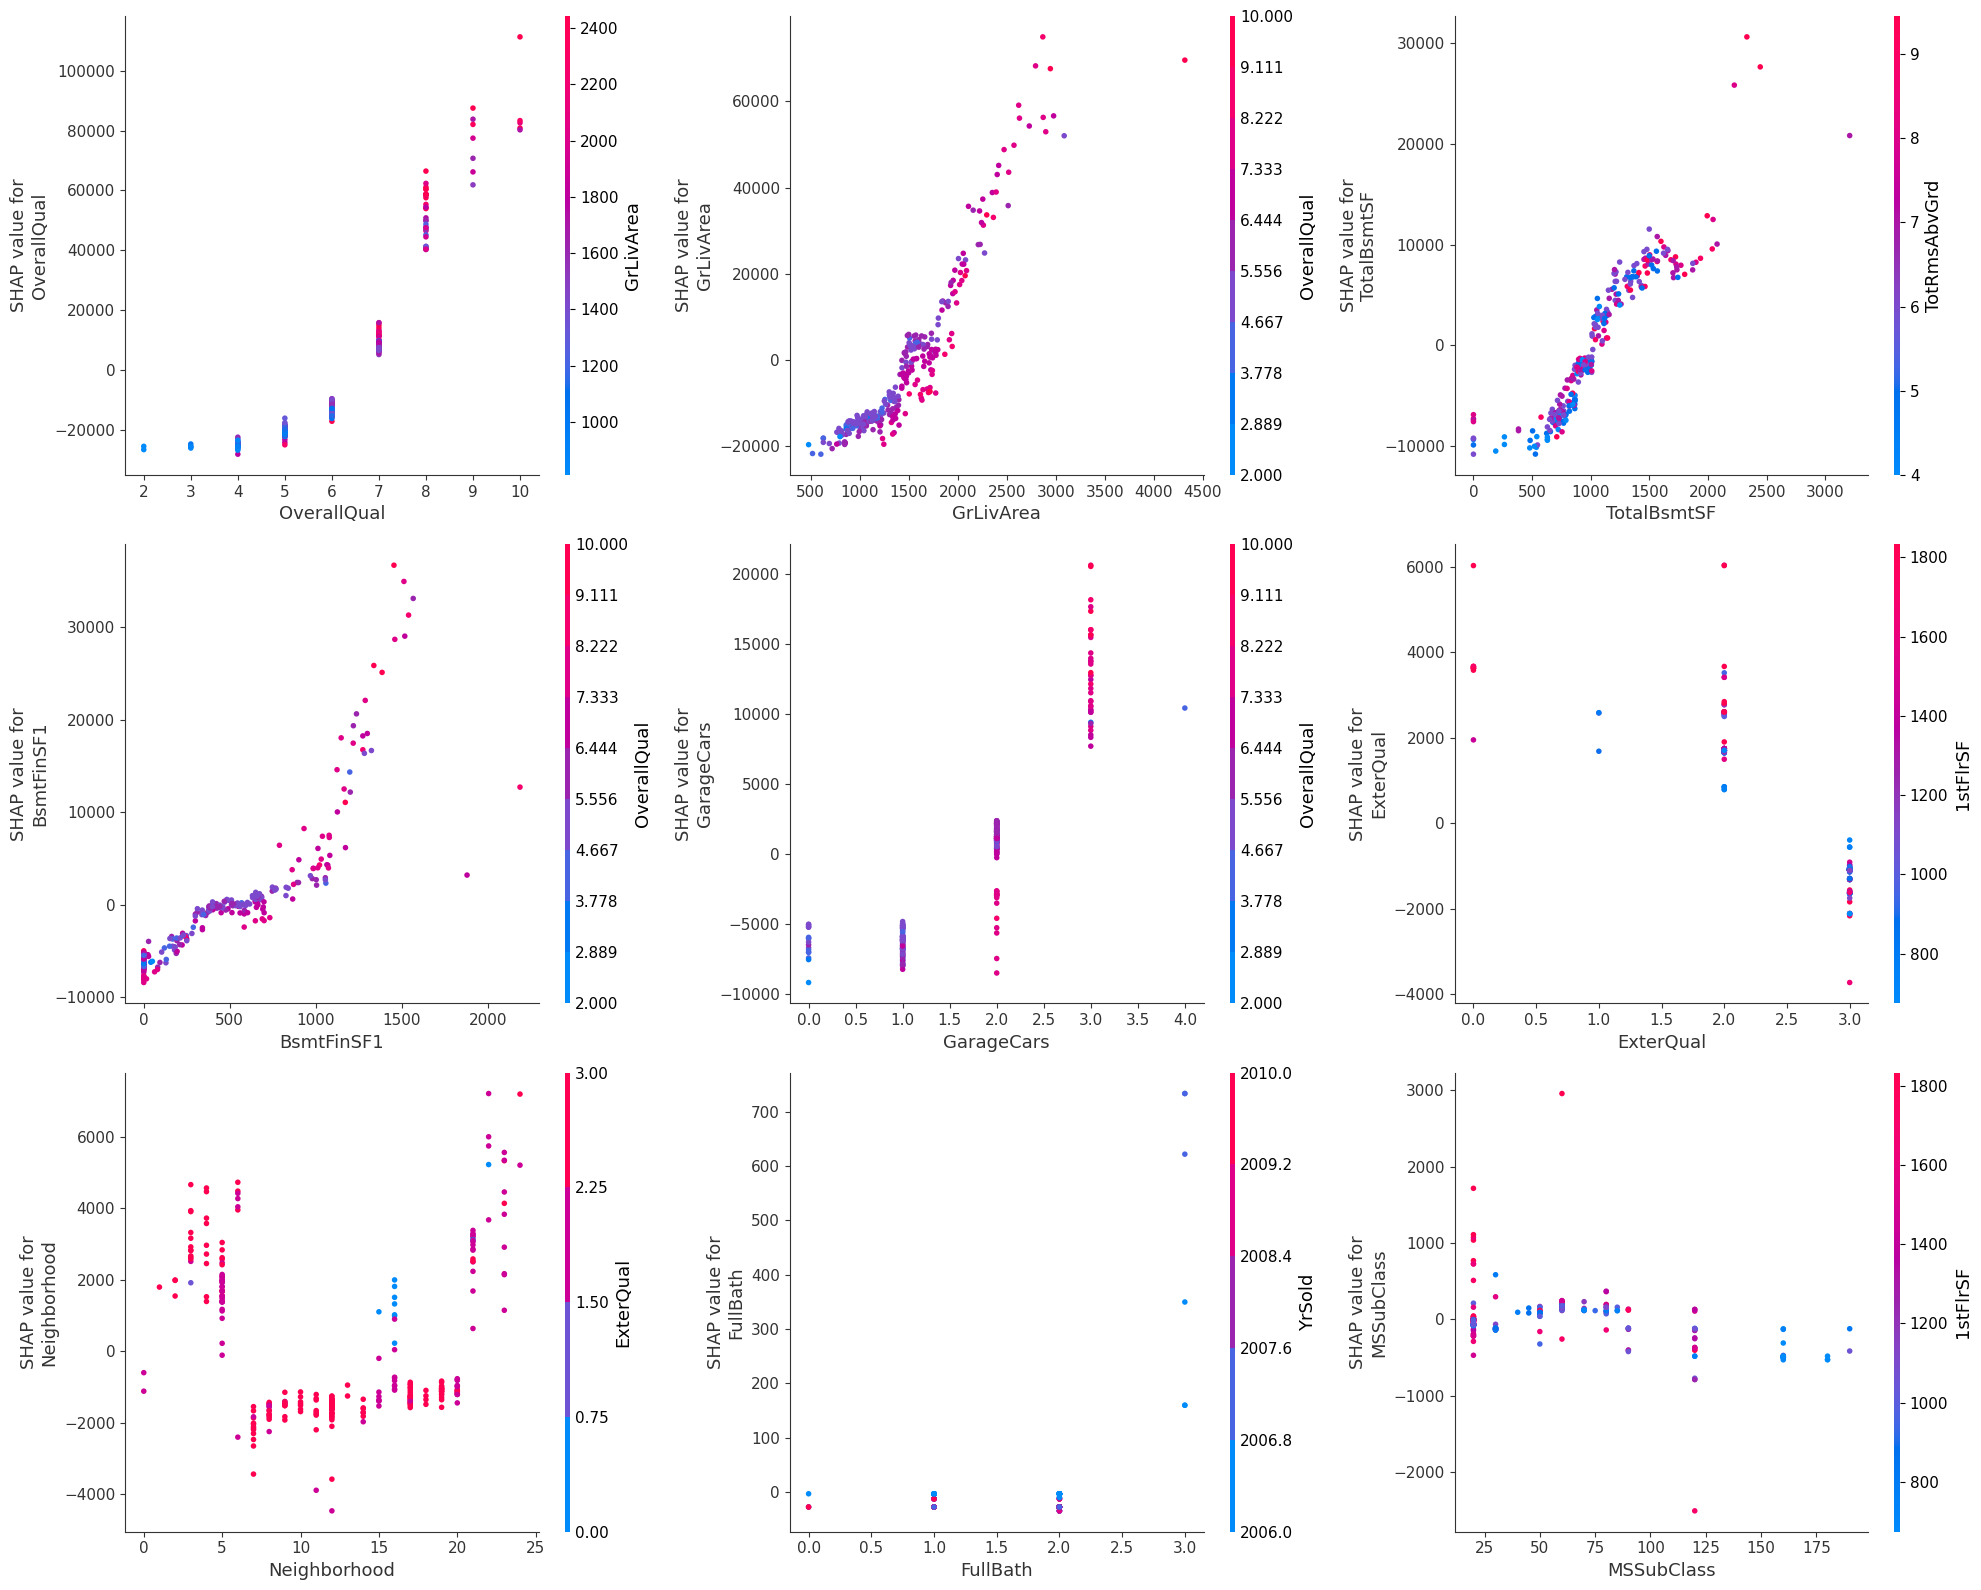

In [188]:
pl_shap2(valx, datx, 'OverallQual, GrLivArea, TotalBsmtSF, BsmtFinSF1, GarageCars, ExterQual, Neighborhood, FullBath, MSSubClass'.split(", "))

**Insight**
- What's the difference between this and the eda plot?
- Does it account for interaction/correlated term as well?
- Guess there's something to do with partial dependence plot (so, a marginal effect of a certain feature?)
- Nah, that's it.

In [211]:
# preprocess the data first
def moData(model, data, pre="pre", alg="model"):
  idx = data.index

  pre = model.named_steps[pre]
  data = pre.transform(data)
  fitur = [j.split("__")[1] for j in pre.get_feature_names_out()]
  mod = model.named_steps[alg]

  dat = pd.DataFrame(data, columns=fitur)
  dat.index = idx

  return mod, dat

# print it into shap.
def idShap(model, data, pre="pre", alg="model", idx = 892, thr=0.1):
  mod, dat = moData(model, data)

  # individual
  datn = dat.loc[[idx]]

  explainer = shap.TreeExplainer(mod, approximate=True)
  shap_values = explainer.shap_values(datn)

  # wf = shap.plots.waterfall(explainer(datn)[0], max_display=14)

  # change the contribution_threshold.
  return shap.force_plot(explainer.expected_value, shap_values, datn, matplotlib=True, show=False, contribution_threshold=thr)

<Figure size 640x480 with 0 Axes>

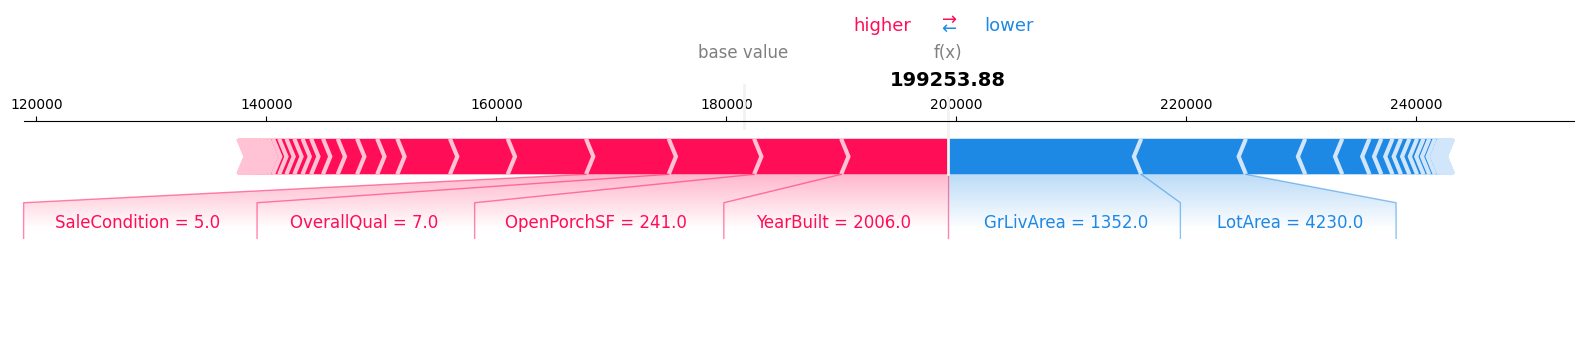

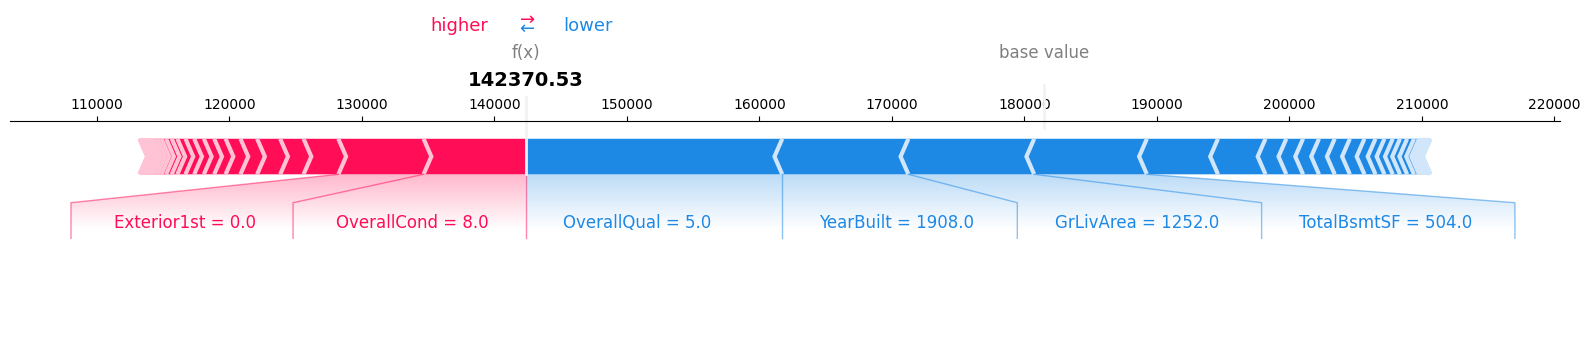

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1317,120,FV,47.0,4230,Pave,Pave,Reg,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,4,2007,New,Partial
184,50,RL,92.0,7438,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,6,2006,WD,Normal


In [231]:
# couldn't add title lol
for j in X_te.index[29:31]:
    idShap(model, X_te, idx=j, thr=0.09)
plt.show()
plt.tight_layout()

X_te[29:31]


**Insight**
- Individual SHAP value! We got two example.
- For the first one, its price is predicted to be higher than base value (mean house price: ~18k) around 20k, which is positively affected by: YearBuilt 2006, OpenPorchSF 241, OverallQual 7, SaleCondition 5, etc; while negatively affected by: GrLivArea 1352, LotArea 4230, etc.
- For the second one, its price is predicted to be lower than base value (mean house price: ~18k) around 14k, which is influenced positively by: OverallCond 8 and Exteriro1st 0 (AsbShng); while negatively influenced by: OverallQual 5, YearBuilt 1908, GrLivArea 1252, and TotalBsmtSF 504  

In [243]:
X_te.Exterior1st[29:31]

,Exterior1st
1317,VinylSd
184,AsbShng
